In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

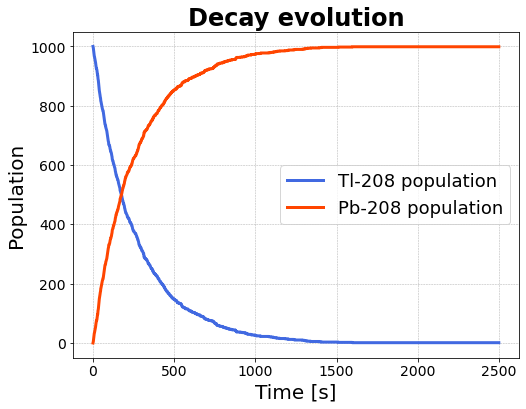

In [2]:
tau = 3.052*60 #half-life [seconds]
Tl_count = 1000   #counter of Tl population set to 1000 at beginning
Pb_count = 0      #counter of Pb population set to 0 at beginning

#Take steps in time of 1 second and at each time-step (total time: about 40 min)
time_tot = np.arange(2500)
Tl_t = [] #array with Tl population at each time step t
Pb_t = [] #array with Pb population at each time step t

#Decide whether each Tl atom has decayed or not, accordingly to the probability  𝑝(𝑡)=1−2−𝑡/𝜏 . 
def p(t):
    return 1 - 2**(-t/tau)

for t in time_tot:
    for i in range(Tl_count):
        x = np.random.uniform() #pick random number between 0 and 1
        if x < p(1):   #Probability of decaying in 1 sec is the same as picking x smaller than p(1)  
            Tl_count -= 1
            Pb_count += 1 #Subtract number of decayed atoms from Tl sample and add them to the Pb one.
            if Tl_count == 0: 
                break #stop if Tl population becomes zero 
    Tl_t.append(Tl_count)
    Pb_t.append(Pb_count)

    
# Plot the evolution of the two sets as a function of time
plt.figure(figsize=(8,6))
plt.plot(time_tot, Tl_t, c="royalblue", linewidth = 3, label="Tl-208 population")
plt.plot(time_tot, Pb_t, c="orangered", linewidth = 3, label="Pb-208 population")
plt.title("Decay evolution", weight='bold', size=24)
plt.ylabel("Population", fontsize=20)
plt.xlabel("Time [s]", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(linestyle="--", linewidth=0.5)
plt.legend(loc='best', fontsize=18)
plt.show()

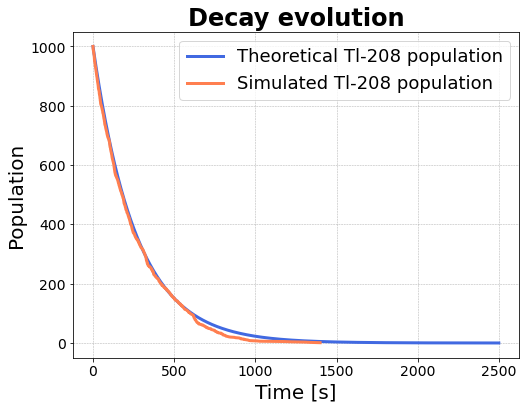

In [3]:
#Repeat the exercise by means of the inverse transform method

def pdf(t):
    p = 1000*2**(-t/tau)
    return p

def inv_cdf(x):
    t = -tau*(np.log(1-x)/np.log(2))
    return t

#Draw 1000 random numbers from the non-uniform probability distribution 
u = np.random.uniform(0,1,1000)
v = np.sort(inv_cdf(u)) #put decay times in order from smallest to highest 

#Make a plot showing the number of atoms that have not decayed as a function of time
y = range(1000,0,-1) #ints from 0 to 1000 in reverse
plt.figure(figsize=(8,6))
plt.plot(time_tot, pdf(time_tot), linewidth=3, c="royalblue", label="Theoretical Tl-208 population")
plt.plot(v, y, linewidth=3,  c="coral", label="Simulated Tl-208 population")
plt.title('Decay evolution', weight='bold', size=24)
plt.ylabel("Population", fontsize=20)
plt.xlabel("Time [s]", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(linestyle="--", linewidth=0.5)
plt.legend(loc='best', fontsize=18)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
# Define parameters
Z = 79                # atomic number
e = 1.602176634E-19   # elementary charge
E = 7.7*1000000*e     # energy
alpha = 1000000       # particles shot
a0 = 5.291777721092E-11  # Bohr radius
eps0 = 8.85418781762E-12 # vacuum permittivity

# Bounce back condition 𝜃=𝜋/2 --> tan𝜃/2 = 1
b0 = (Z*e**2)/(2*np.pi*eps0*E)

# Beam distribution
sigma = a0/100
x = np.random.normal(0, sigma, alpha)
y = np.random.normal(0, sigma, alpha)

# Count particles bounced back
count = 0
for i in range(alpha):
    bi = np.sqrt(x[i]**2 + y[i]**2) # b of the i-th particle of the beam
    if bi < b0: # bounce back condition
        count += 1
        
# Compute fraction of bounced back particles
print("The fraction of bounced back particles is:", count/alpha)

The fraction of bounced back particles is: 0.001529


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [11]:
# Consider the function
def f(x):
    return (np.sin(1/(x*(2-x))))**2

# Compute the integral between 0 and 2 with the hit/miss method
N = 100000 #number of samples
count = 0 

for i in range(N):
    x = 2*np.random.random()
    y = np.random.random()
    if y < f(x): count+=1
        
I_hm = 2*count/N

In [12]:
# Repeat the integral with the mean value method
x = 2*np.random.random(N) # probe uniformly at random the function domain
I_mv = (2/N)*np.sum(f(x)) 

In [13]:
# Evaluate errors and compare
I_corr = 1.4514
print("The correct value is:", I_corr, "\n")

print("The result obtained from the hit or miss method is:", I_hm)
print("with relative error:", 100*abs(I_corr-I_hm)/I_corr,"% \n")

print("The result obtained from the mean value method is:", I_mv)
print("with relative error:", 100*abs(I_corr-I_mv)/I_corr,"%")

The correct value is: 1.4514 

The result obtained from the hit or miss method is: 1.45536
with relative error: 0.27284001653575607 % 

The result obtained from the mean value method is: 1.4499461065047317
with relative error: 0.10017179931572039 %


The second method on average provides better results but it depends on the sample.

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [14]:
# 2D circle
def f(x,y):
    if x**2 + y**2 <= 1: return 1
    else: return 0

N = 1000000 #number of samples

x = np.random.uniform(-1,1,N) # probe uniformly at random the function domain [-1,1]
y = np.random.uniform(-1,1,N)
A = 2*2 #integration volume

v = np.vectorize(f)
Area_mv = (A/N)*np.sum(v(x,y)) #using mean value method

print("The area of a circle of radius 1 is:", np.pi)
print("The result obtained integrating with mean value method is:", Area_mv)
print("With relative error:", 100*abs(np.pi-Area_mv)/np.pi,"%")

The area of a circle of radius 1 is: 3.141592653589793
The result obtained integrating with mean value method is: 3.1444799999999997
With relative error: 0.09190709072060406 %


In [15]:
# generalize to 10D sphere

def sph_10d(r):
    if r <= 1: return 1
    else: return 0

r_comps = np.random.uniform(-1,1, size=(N,10)) # probe uniformly at random the function domain for each coordinate [-1,1]
r = np.sum(r_comps**2,axis=1)
V = 2**10 # integration volume

v10 = np.vectorize(sph_10d)
vol10D_mv = np.sum(v10(r))*V/N #using mean value method
real_vol = np.pi**(5)/(120)    #real volume of 10D sphere

print("The volume of the 10D sphere of radius 1 is:", real_vol)
print("The result obtained integrating with mean value method is:",vol10D_mv)
print("With relative error:", 100*abs(real_vol-vol10D_mv)/real_vol,"%")

The volume of the 10D sphere of radius 1 is: 2.550164039877345
The result obtained integrating with mean value method is: 2.522112
With relative error: 1.1000092322960677 %


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [26]:
I_corr = 0.838932960 #true value

def f(x):
    return 1/((np.exp(x)+1)*np.sqrt(x))

def w(x):
    return 1/np.sqrt(x)

y = np.random.uniform(0,1,N)**2 #do the square to focus the sampling around zero
N = 100000

w_int = 2 #integral of weight function in the domain [0,1]
I_is = np.sum(f(y)/w(y))*w_int/N


print("The correct value is:", I_corr, "\n")
print("The result obtained with importance sampling is:", I_is)
print("with relative error:", 100*abs(I_corr-I_is)/I_corr,"% \n")

The correct value is: 0.83893296 

The result obtained with importance sampling is: 0.8384820815713953
with relative error: 0.05374427398879348 % 

